# Batch effect removal using scVI



## Installs the required libraries


In [ ]:
!pip install anndata
!pip install opentsne
!pip install scanpy
!pip install scvi-tools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.9 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=1a373947c2f3f14629b047d0abcdb3b912f6e3fcfb9ac70bf4b09205144f98fa
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from os.path import abspath, dirname, join

import scipy.sparse as sp
import math
import numpy as np
import torch
from torch.utils.data import Dataset
import pandas as pd
from sklearn import manifold
from sklearn import preprocessing

import anndata
import seaborn as sns

import matplotlib.pyplot as plt

import openTSNE

import scanpy as sc
from scipy import sparse
import scvi

from openTSNE import TSNE, TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data preprocessing


In [ ]:
tpm_table = pd.read_table('/content/drive/MyDrive/Mag/athaliana_tpm_trimmed.tsv')
metadata_table = pd.read_table('/content/drive/MyDrive/Mag/metadata_T.tsv')

<ipython-input-4-2d6475ad42c7>:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  tpm_table = pd.read_table('/content/drive/MyDrive/Mag/athaliana_tpm_trimmed.tsv')


In [ ]:
annotated_tpm = pd.read_table('/content/drive/MyDrive/Mag/athaliana_annotated.tsv')
annotated_tpm = annotated_tpm.drop('qc_rate', axis=1)

In [ ]:
metadata_table = pd.read_table('/content/drive/MyDrive/Mag/metadata_T.tsv')

In [ ]:
metadata_table.set_index('SRR_accession', inplace=True)
#tpm_table.set_index(tpm_table.columns[0], inplace=True)
annotated_tpm.set_index('gene_id', inplace=True)

In [ ]:
annotated_tpm = metadata_table.join(annotated_tpm, how='inner')

In [ ]:
tpm_table = annotated_tpm

In [ ]:
tpm_table_test = pd.concat([tpm_table, annotated_tpm])

In [ ]:
test = tpm_table_test.index.value_counts()

In [ ]:
tpm_table_test = tpm_table_test.groupby(tpm_table_test.index).first()

In [ ]:
tpm_table

,SRR_accession,sra_study,experiment_library_strategy,experiment_library_selection,experiment_instrument_model,perturbation_group,tissue_super,gene_id,AT1G01010.1,AT1G01020.1,...,ATMG01290.1,ATMG01300.1,ATMG01310.1,ATMG01320.1,ATMG01330.1,ATMG01350.1,ATMG01360.1,ATMG01370.1,ATMG01400.1,ATMG01410.1
0,DRR008476,DRP001015,RNA-Seq,cDNA,Illumina Genome Analyzer IIx,NaN,NaN,DRR090011,20.528919,1.894016,...,0.000000,0.0,0.0,0.247440,0.000000,0.000000,0.582971,0.000000,0.000000,0.000000
1,DRR008477,DRP001015,RNA-Seq,cDNA,Illumina Genome Analyzer IIx,NaN,NaN,DRR090016,18.904490,0.000000,...,0.000000,0.0,0.0,0.241848,0.080616,0.000000,0.564313,0.040308,0.000000,0.040308
2,DRR008478,DRP001015,RNA-Seq,cDNA,Illumina Genome Analyzer IIx,NaN,NaN,DRR090013,33.696263,0.423473,...,0.000000,0.0,0.0,0.233354,0.093341,0.000000,0.513378,0.000000,0.000000,0.000000
3,DRR016112,DRP001756,RNA-Seq,cDNA,Illumina HiSeq 2000,NaN,NaN,DRR090018,35.141749,0.531938,...,0.000000,0.0,0.0,0.125192,0.000000,0.000000,0.379228,0.042136,0.000000,0.042136
4,DRR016113,DRP001756,RNA-Seq,cDNA,Illumina HiSeq 2000,NaN,NaN,DRR090012,21.665782,0.000000,...,0.000000,0.0,0.0,0.043593,0.130779,0.000000,0.217966,0.130779,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,ERR11344906,ERP146938,RNA-Seq,Oligo-dT,Illumina HiSeq 3000,NaN,NaN,SRR9729451,7.958812,0.608200,...,0.872199,0.0,0.0,157.684781,4.088431,3.815869,807.492345,1.362810,0.163537,1.471835
2529,ERR11344907,ERP146938,RNA-Seq,Oligo-dT,Illumina HiSeq 3000,NaN,NaN,SRR9729452,0.697591,0.394778,...,0.465060,0.0,0.0,138.893540,3.580965,3.813742,684.940939,0.418554,0.232530,0.883615
2530,ERR11344908,ERP146938,RNA-Seq,Oligo-dT,Illumina HiSeq 3000,NaN,NaN,SRR9729453,0.914717,1.388492,...,0.724151,0.0,0.0,143.941842,3.239624,2.972980,690.764118,0.381132,0.152453,0.876604
2531,ERR11344909,ERP146938,RNA-Seq,Oligo-dT,Illumina HiSeq 3000,NaN,NaN,SRR9729455,12.472602,2.054720,...,0.623630,0.0,0.0,172.939842,5.448558,4.726460,893.694727,0.689275,0.229758,1.312905


In [ ]:
tpm_table_test = tpm_table_test.groupby(tpm_table_test.index).first()

In [ ]:
tpm_table_test

,sra_study,experiment_library_strategy,experiment_library_selection,experiment_instrument_model,perturbation_group,tissue_super,AT1G01010.1,AT1G01020.1,AT1G01020.2,AT1G01020.3,...,ATMG01290.1,ATMG01300.1,ATMG01310.1,ATMG01320.1,ATMG01330.1,ATMG01350.1,ATMG01360.1,ATMG01370.1,ATMG01400.1,ATMG01410.1
DRR029379,DRP003066,RNA-Seq,RANDOM,Illumina Genome Analyzer IIx,None,None,34.226802,0.000000,14.886634,4.407612e-07,...,0.000000,0.000000,0.000000,0.000000,0.096414,0.000000,0.578481,0.385654,0.0,0.000000
DRR031041,DRP006520,RNA-Seq,RANDOM,Illumina Genome Analyzer IIx,None,None,4.766623,0.052069,12.299716,2.288512e-01,...,0.000000,0.000000,0.000000,0.635550,0.556106,0.079444,1.509431,0.556106,0.0,0.158887
DRR031043,DRP006520,RNA-Seq,RANDOM,Illumina Genome Analyzer IIx,None,None,22.551978,0.000000,10.374748,1.123904e+00,...,0.152378,0.000000,0.076189,0.000000,0.457135,0.000000,1.523782,0.838080,0.0,0.156937
DRR031048,DRP006520,RNA-Seq,RANDOM,Illumina Genome Analyzer IIx,None,None,2.833645,0.000000,11.359871,4.458896e+00,...,0.000000,0.000000,0.000000,0.210473,0.141682,0.000000,1.275140,0.283365,0.0,0.070841
DRR031049,DRP006520,RNA-Seq,RANDOM,Illumina Genome Analyzer IIx,None,None,3.211263,0.000010,11.624616,3.503206e-05,...,0.078323,0.000000,0.000000,0.000000,0.234970,0.000000,1.253176,0.391617,0.0,0.084893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR9995098,SRP218723,RNA-Seq,cDNA,Illumina HiSeq X Ten,None,None,10.263252,8.636863,0.271686,5.771498e-01,...,0.084125,0.000000,0.000000,0.443977,5.888751,0.084125,2.355500,2.523750,0.0,0.084125
SRR9995099,SRP218723,RNA-Seq,cDNA,Illumina HiSeq X Ten,None,None,18.123945,6.468130,1.497293,1.502058e+00,...,0.000000,0.184556,0.000000,0.757550,2.978113,0.000000,4.509714,5.700959,0.0,0.000000
SRR9995100,SRP218723,RNA-Seq,cDNA,Illumina HiSeq X Ten,None,None,3.322365,6.290166,0.487208,7.888214e-01,...,0.390867,0.000000,0.000000,0.195433,3.517799,0.000000,2.833782,4.788115,0.0,0.000000
SRR9995101,SRP218723,RNA-Seq,cDNA,Illumina HiSeq X Ten,None,None,5.287046,7.457304,0.036845,4.365146e-01,...,0.073431,0.000000,0.000000,1.321761,1.982642,0.000000,3.671559,7.122825,0.0,0.000000


In [ ]:
tpm_table_test.drop_duplicates(inplace=True)
metadata_table.drop_duplicates(inplace=True)

In [ ]:
metadata_table.set_index('SRR_accession', inplace=True)
tpm_table.set_index(tpm_table.columns[0], inplace=True)

In [ ]:
metadata_table.set_index('SRR_accession', inplace=True)
tpm_table.set_index(tpm_table.columns[0], inplace=True)

KeyError: "None of ['SRR_accession'] are in the columns"

In [ ]:
file = open('/content/drive/MyDrive/Mag/relevant_studies.txt')

batches = []

for line in file :
  batches.append(line[:-1])

In [ ]:
tpm_table = tpm_table[tpm_table['sra_study'].isin(batches)]

In [ ]:
#adata_raw = sc.read_h5ad("/content/drive/MyDrive/Mag/anndata.h5ad")
#sc.pp.filter_cells(adata_raw, min_cells=1)

#tpm_table.drop_duplicates(inplace=True)
#metadata_table.drop_duplicates(inplace=True)

#metadata_table.set_index('SRR_accession', inplace=True)
#tpm_table.set_index('SRR_accession', inplace=True)
tpm_table = metadata_table.join(tpm_table, how='inner')

#batches = tpm_table['sra_study'].value_counts()
#test = batches[batches > 5].index.values
#tpm_table = tpm_table[(tpm_table['sra_study'].isin(test)) | (tpm_table['sra_study'].isin(batches))]



#tpm_table.dropna(inplace=True)

#print(tpm_table.isin([np.inf, -np.inf]).sum().sum())
#print(tpm_table.isnull().sum().sum())


ValueError: columns overlap but no suffix specified: Index(['sra_study', 'experiment_library_strategy',
       'experiment_library_selection', 'experiment_instrument_model',
       'perturbation_group', 'tissue_super'],
      dtype='object')

In [ ]:
instruments = tpm_table['experiment_instrument_model'].value_counts()
test = instruments[instruments > 50].index.values
tpm_table = tpm_table[tpm_table['experiment_instrument_model'].isin(test)]


In [ ]:
tpm_table2 = tpm_table[(tpm_table['qc_rate'] > 99.925) | (tpm_table['sra_study'].isin(batches))]

In [ ]:
tpm_table2.drop(['qc_rate'], inplace=True, axis=1)
#tpm_table.dropna(inplace=True)

<ipython-input-23-9b12d883cf43>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tpm_table2.drop(['qc_rate'], inplace=True, axis=1)


In [ ]:
tpm_table_test.to_csv('athaliana_tpm_trimmed.tsv', sep='\t')
!cp athaliana_tpm_trimmed.tsv "/content/drive/MyDrive/Mag/"

In [ ]:
#tpm_table.dropna(inplace=True)
#metadata_table = pd.read_table('/content/drive/MyDrive/Mag/metadata_T.tsv', index_col=0)

tpm_table

,sra_study,experiment_library_strategy,experiment_library_selection,experiment_instrument_model,perturbation_group,tissue_super,AT1G01010.1,AT1G01020.1,AT1G01020.2,AT1G01020.3,...,ATMG01300.1,ATMG01310.1,ATMG01320.1,ATMG01330.1,ATMG01350.1,ATMG01360.1,ATMG01370.1,ATMG01400.1,ATMG01410.1,qc_rate
DRR090012,DRP004882,RNA-Seq,Oligo-dT,NextSeq 500,control,young_seedling,21.665782,0.000000,5.727221,0.000000,...,0.0,0.0,0.043593,0.130779,0.000000,0.217966,0.130779,0.000000,0.000000,99.7257
DRR090013,DRP004882,RNA-Seq,Oligo-dT,NextSeq 500,control,young_seedling,33.696263,0.423473,7.150235,2.319544,...,0.0,0.0,0.233354,0.093341,0.000000,0.513378,0.000000,0.000000,0.000000,99.2620
DRR090014,DRP004882,RNA-Seq,Oligo-dT,NextSeq 500,control,young_seedling,29.251707,1.299907,8.839646,0.000000,...,0.0,0.0,0.620346,0.190876,0.000000,1.145254,0.238595,0.000000,0.047719,99.6297
DRR090015,DRP004882,RNA-Seq,Oligo-dT,NextSeq 500,control,young_seedling,33.846199,1.825191,6.485996,0.005963,...,0.0,0.0,0.504483,0.229310,0.000000,2.109655,0.000000,0.000000,0.000000,99.9817
DRR090016,DRP004882,RNA-Seq,Oligo-dT,NextSeq 500,control,young_seedling,18.904490,0.000000,5.527810,1.824219,...,0.0,0.0,0.241848,0.080616,0.000000,0.564313,0.040308,0.000000,0.040308,99.5500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR9729451,SRP215927,RNA-Seq,cDNA,Illumina HiSeq 2000,mutant,mature_leaf,7.958812,0.608200,0.770991,0.000000,...,0.0,0.0,157.684781,4.088431,3.815869,807.492345,1.362810,0.163537,1.471835,99.9843
SRR9729452,SRP215927,RNA-Seq,cDNA,Illumina HiSeq 2000,mutant,mature_leaf,0.697591,0.394778,1.235628,0.003344,...,0.0,0.0,138.893540,3.580965,3.813742,684.940939,0.418554,0.232530,0.883615,99.9824
SRR9729453,SRP215927,RNA-Seq,cDNA,Illumina HiSeq 2000,mutant,mature_leaf,0.914717,1.388492,0.353927,0.000000,...,0.0,0.0,143.941842,3.239624,2.972980,690.764118,0.381132,0.152453,0.876604,99.9768
SRR9729454,SRP215927,RNA-Seq,cDNA,Illumina HiSeq 2000,mutant,mature_leaf,10.533983,0.790660,1.271864,0.803798,...,0.0,0.0,179.266658,4.677678,4.420037,882.386810,1.289124,0.147328,1.657445,99.9847


In [ ]:
tpm_table = pd.read_table('/content/drive/MyDrive/Mag/athaliana_tpm_trimmed.tsv')


<ipython-input-4-dd8877614443>:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  tpm_table = pd.read_table('/content/drive/MyDrive/Mag/athaliana_tpm_trimmed.tsv')


In [ ]:
#tpm_table.set_index(tpm_table.columns[0], inplace=True)

tpm_table

,sra_study,experiment_library_strategy,experiment_library_selection,experiment_instrument_model,perturbation_group,tissue_super,AT1G01010.1,AT1G01020.1,AT1G01020.2,AT1G01020.3,...,ATMG01290.1,ATMG01300.1,ATMG01310.1,ATMG01320.1,ATMG01330.1,ATMG01350.1,ATMG01360.1,ATMG01370.1,ATMG01400.1,ATMG01410.1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
DRR029379,DRP003066,RNA-Seq,RANDOM,Illumina Genome Analyzer IIx,NaN,NaN,34.226802,0.000000,14.886634,4.407612e-07,...,0.000000,0.000000,0.000000,0.000000,0.096414,0.000000,0.578481,0.385654,0.0,0.000000
DRR031041,DRP006520,RNA-Seq,RANDOM,Illumina Genome Analyzer IIx,NaN,NaN,4.766623,0.052069,12.299716,2.288512e-01,...,0.000000,0.000000,0.000000,0.635550,0.556106,0.079444,1.509431,0.556106,0.0,0.158887
DRR031043,DRP006520,RNA-Seq,RANDOM,Illumina Genome Analyzer IIx,NaN,NaN,22.551978,0.000000,10.374748,1.123904e+00,...,0.152378,0.000000,0.076189,0.000000,0.457135,0.000000,1.523782,0.838080,0.0,0.156937
DRR031048,DRP006520,RNA-Seq,RANDOM,Illumina Genome Analyzer IIx,NaN,NaN,2.833645,0.000000,11.359871,4.458896e+00,...,0.000000,0.000000,0.000000,0.210473,0.141682,0.000000,1.275140,0.283365,0.0,0.070841
DRR031049,DRP006520,RNA-Seq,RANDOM,Illumina Genome Analyzer IIx,NaN,NaN,3.211263,0.000010,11.624616,3.503206e-05,...,0.078323,0.000000,0.000000,0.000000,0.234970,0.000000,1.253176,0.391617,0.0,0.084893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR9995098,SRP218723,RNA-Seq,cDNA,Illumina HiSeq X Ten,NaN,NaN,10.263252,8.636863,0.271686,5.771498e-01,...,0.084125,0.000000,0.000000,0.443977,5.888751,0.084125,2.355500,2.523750,0.0,0.084125
SRR9995099,SRP218723,RNA-Seq,cDNA,Illumina HiSeq X Ten,NaN,NaN,18.123945,6.468130,1.497293,1.502058e+00,...,0.000000,0.184556,0.000000,0.757550,2.978113,0.000000,4.509714,5.700959,0.0,0.000000
SRR9995100,SRP218723,RNA-Seq,cDNA,Illumina HiSeq X Ten,NaN,NaN,3.322365,6.290166,0.487208,7.888214e-01,...,0.390867,0.000000,0.000000,0.195433,3.517799,0.000000,2.833782,4.788115,0.0,0.000000


In [ ]:
#X = tpm_table.iloc[0:,6:]
#obs = pd.DataFrame(tpm_table[['sra_study', 'perturbation_group', 'tissue_super', 'experiment_library_strategy', 'experiment_library_selection', 'experiment_instrument_model']])
var = pd.DataFrame(tpm_table.columns[6:])

var = var.rename(columns={0: "gene_id"})
var.set_index('gene_id', inplace=True)


adata_raw = anndata.AnnData(X = tpm_table.iloc[0:,6:],
                        obs = pd.DataFrame(tpm_table[['sra_study', 'perturbation_group', 'tissue_super', 'experiment_library_selection']]),
                        var = var)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
#adata_raw.layers["counts"] = adata_raw.X
#adata_raw.X = adata_raw.X.astype(np.float64)
#adata_raw.X = np.where(adata_raw.X==0, np.nan, adata_raw.X)
#sc.pp.filter_genes(adata_raw, min_cells=1)
#sc.pp.filter_cells(adata_raw, min_genes=1)
#sc.pp.normalize_total(adata_raw)
#sc.pp.log1p(adata_raw)

#adata_raw.X = np.asarray(np.nan_to_num(adata_raw.X), dtype=np.float64)
adata_raw.layers["counts"] = adata_raw.X

In [ ]:
print(np.isnan(adata_raw.X).sum().sum())
print(np.isinf(adata_raw.X).sum().sum())
#sc.pp.log1p(adata_raw)
adata_raw

0
0


AnnData object with n_obs × n_vars = 30313 × 48359
    obs: 'sra_study', 'perturbation_group', 'tissue_super', 'experiment_library_selection', '_scvi_batch', '_scvi_labels'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs'
    layers: 'counts'

In [ ]:
sc.pp.highly_variable_genes(adata_raw)
adata_scvi = adata_raw[:, adata_raw.var["highly_variable"]].copy()

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:295: RuntimeWarning: overflow encountered in expm1
  np.expm1(X, out=X)
/usr/local/lib/python3.10/dist-packages/scanpy/_utils/__init__.py:551: RuntimeWarning: overflow encountered in multiply
  return x * y
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_utils.py:41: RuntimeWarning: overflow encountered in square
  var = mean_sq - mean**2
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_utils.py:41: RuntimeWarning: invalid value encountered in subtract
  var = mean_sq - mean**2


ValueError: cannot specify integer `bins` when input data contains infinity

In [ ]:
cat_cov_list = ['experiment_library_selection']

scvi.model.SCVI.setup_anndata(adata_raw, layer="counts", batch_key='sra_study', categorical_covariate_keys=cat_cov_list)


/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_dataframe_field.py:186: UserWarning: Category 5 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


### Model training


In [ ]:
model_scvi = scvi.model.SCVI(adata_raw, n_hidden=2048, n_latent=64, n_layers=3, dispersion='gene-batch', gene_likelihood='zinb')

model_scvi.view_anndata_setup()

max_epochs_scvi = int(np.min([round((20000 / adata_raw.n_obs) * 400), 400]))

Anndata setup with scvi-tools version 1.2.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'sra_study',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['experiment_library_selection'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  150  │
│         n_cells          │ 2206  │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 48359 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sra_study'] │ DRP004882  │          0          │
│                        │ DRP005301  │          1          │
│                        │ DRP005877  │          2          │
│                        │ DRP005881  │          3          │
│                        │ DRP006827  │          4          │
│                        │ DRP006830  │          5          │
│                        │ DRP006866  │          6          │
│                        │ ERP015521  │          7          │
│                        │ ERP015703  │          8          │
│                        │ ERP015851  │          9          │
│                        │ ERP109042  │         10          │
│                        │ ERP111840  │         11          │
│                        │ ERP116402  │         12          │
│                        │ ERP121038  │         13          │
│                        │ ERP122150  │         14          │
│                        │ ERP128459  │         15          │
│                        │ SRP012153  │         16          │
│                        │ SRP014919  │         17          │
│                        │ SRP019502  │         18          │
│                        │ SRP032274  │         19          │
│                        │ SRP034742  │         20          │
│                        │ SRP040029  │         21          │
│                        │ SRP040120  │         22          │
│                        │ SRP040674  │         23          │
│                        │ SRP042088  │         24          │
│                        │ SRP042365  │         25          │
│                        │ SRP043607  │         26          │
│                        │ SRP044746  │         27          │
│                        │ SRP044776  │         28          │
│                        │ SRP047297  │         29          │
│                        │ SRP047300  │         30          │
│                        │ SRP047525  │         31          │
│                        │ SRP050945  │         32          │
│                        │ SRP051400  │         33          │
│                        │ SRP052825  │         34          │
│                        │ SRP053347  │         35          │
│                        │ SRP055503  │         36          │
│                        │ SRP057076  │         37          │
│                        │ SRP057258  │         38          │
│                        │ SRP060410  │         39          │
│                        │ SRP063421  │         40          │
│                        │ SRP072787  │         41          │
│                        │ SRP073379  │         42          │
│                        │ SRP073511  │         43          │
│                        │ SRP074890  │         44          │
│                        │ SRP075422  │         45          │
│                        │ SRP076403  │         46          │
│                        │ SRP076533  │         47          │
│                        │ SRP081055  │         48          │
│                        │ SRP082192  │         49          │
│                        │ SRP090526  │         50          │
│                        │ SRP092350  │         51          │
│                        │ SRP096376  │         52          │
│                        │ SRP096554  │         53          │
│                        │ SRP099108  │         54          │
│                        │ SRP108542  │         55          │
│                        │ SRP111711  │         56          │
│                        │ SRP113516  │         57          │
│                        │ SRP115032  │         58          │
│                        │ SRP117759  │         59          │
│                        │ SRP11

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                     extra_categorical_covs State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃              Source Location              ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['experiment_library_selection'] │  Oligo-dT  │          0          │
│                                           │   PolyA    │          1          │
│                                           │   RANDOM   │          2          │
│                                           │    cDNA    │          3          │
│                                           │            │                     │
└───────────────────────────────────────────┴────────────┴─────────────────────┘

In [ ]:
max_epochs_scvi

247

In [ ]:
model_scvi.train(max_epochs=max_epochs_scvi)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


In [ ]:
file = open('/content/drive/MyDrive/Mag/relevant_studies.txt')

batches = []

for line in file :
  batches.append(line[:-1])


len(batches)

173

In [ ]:
adata_trim = adata_raw.copy()

tpm_col = pd.read_table('/content/drive/MyDrive/Mag/columns.tsv')

adata_trim = adata_trim[adata_trim.obs.sra_study.isin(batches)]
adata_trim = adata_trim[adata_trim.obs['tissue_super'].isin(['mature_flower', 'mature_root', 'seed', 'mature_leaf', 'young_seedling'])].copy()
adata_trim


AnnData object with n_obs × n_vars = 1146 × 48359
    obs: 'sra_study', 'perturbation_group', 'tissue_super', 'experiment_library_selection', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs'
    layers: 'counts'

In [ ]:
model_scvi = model_scvi.load('/content/drive/MyDrive/Mag/vae_model_tpm_cov1.pt', adata_raw)

INFO     File /content/drive/MyDrive/Mag/vae_model_tpm_cov1.pt/model.pt already downloaded                         


/usr/local/lib/python3.10/dist-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=map_locat

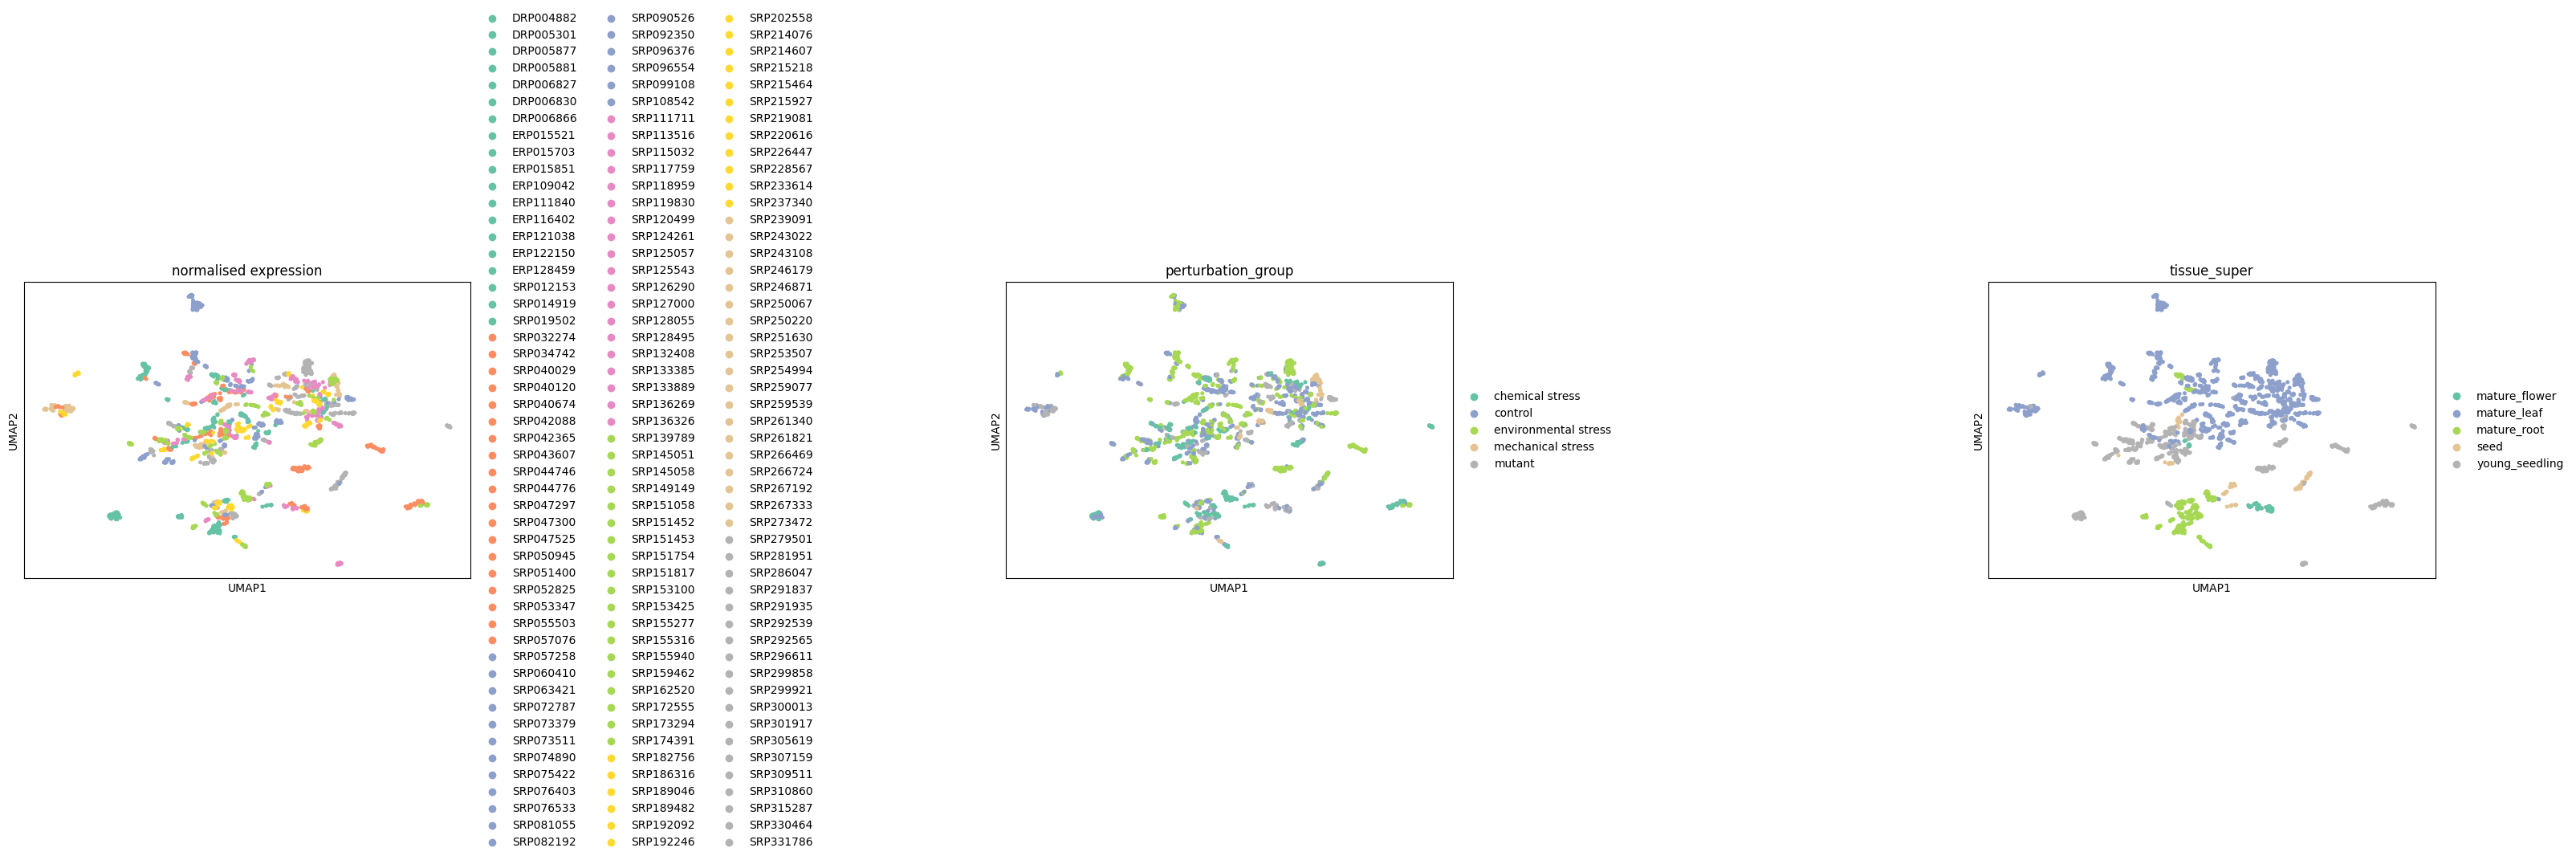

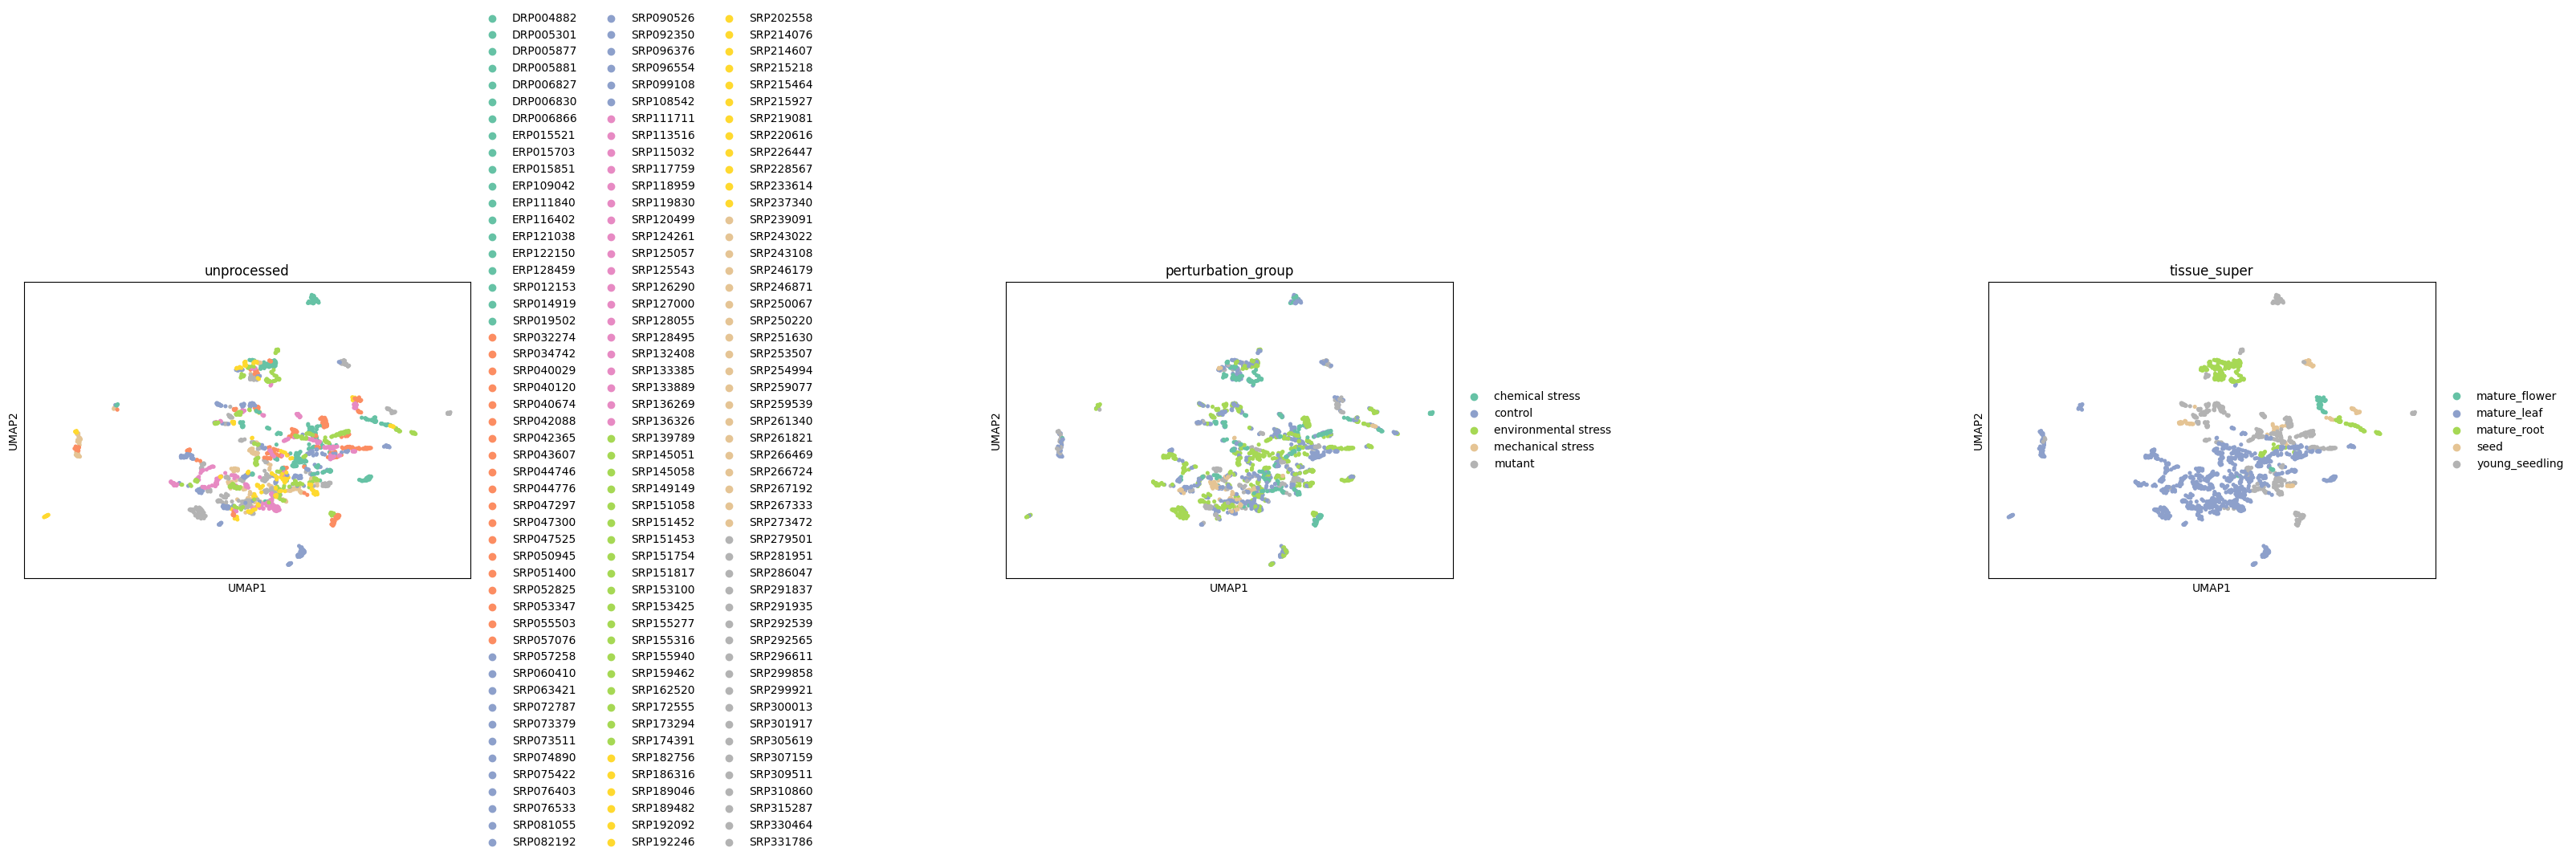

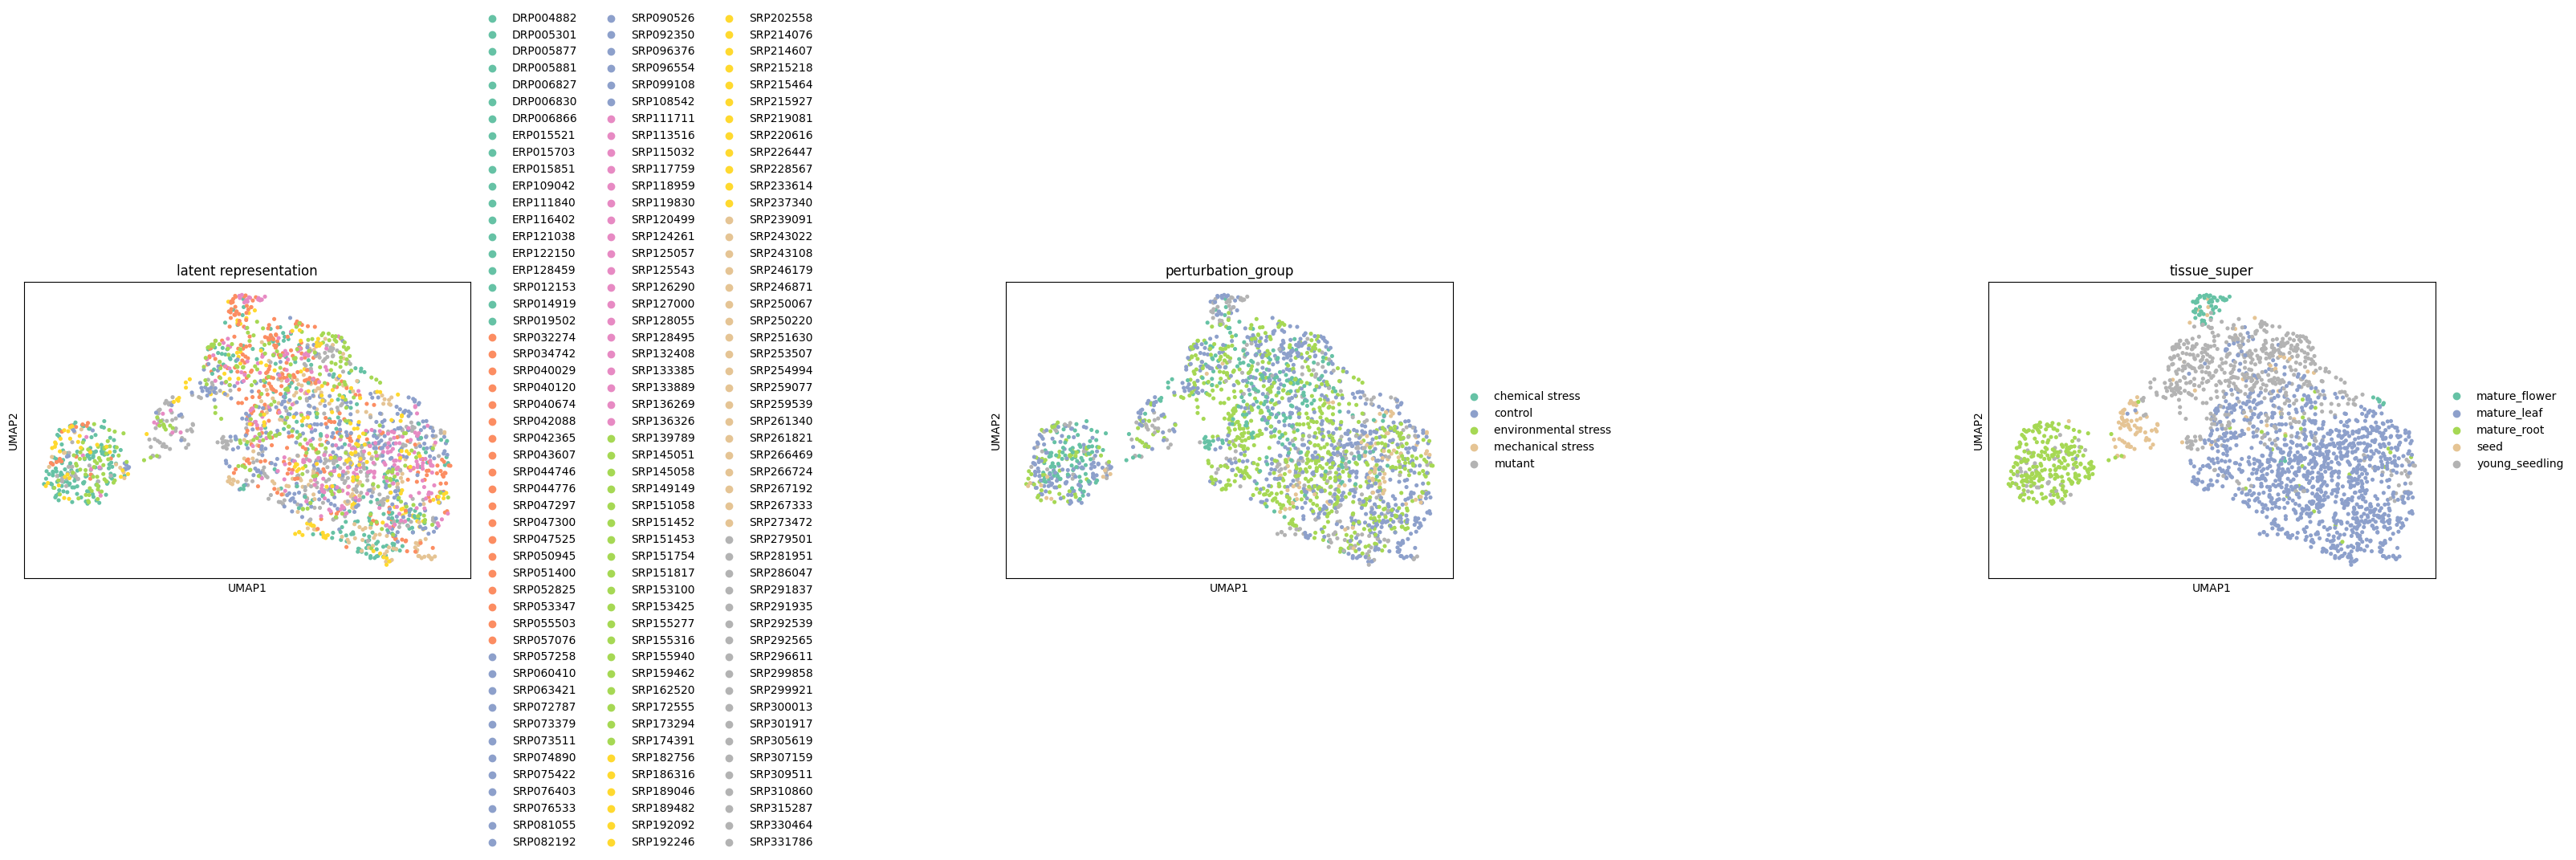

In [ ]:
adata_raw.obsm["X_scVI_norm"] = model_scvi.get_normalized_expression(adata_raw)

sc.pp.neighbors(adata_raw, use_rep="X_scVI_norm")
sc.tl.umap(adata_raw)

sc.pl.umap(adata_raw, color=['sra_study', 'perturbation_group', 'tissue_super'], title='normalised expression', palette='Set2', wspace=1)


sc.pp.neighbors(adata_raw, use_rep='X')
sc.tl.umap(adata_raw)

sc.pl.umap(adata_raw, color=['sra_study', 'perturbation_group', 'tissue_super'], title='unprocessed', palette='Set2', wspace=1)


adata_raw.obsm["X_scVI_lat"] = model_scvi.get_latent_representation(adata_raw)

sc.pp.neighbors(adata_raw, use_rep="X_scVI_lat")
sc.tl.umap(adata_raw)

sc.pl.umap(adata_raw, color=['sra_study', 'perturbation_group', 'tissue_super'], title='latent representation', palette='Set2', wspace=1)



INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_dataframe_field.py:224: UserWarning: Category 226 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(


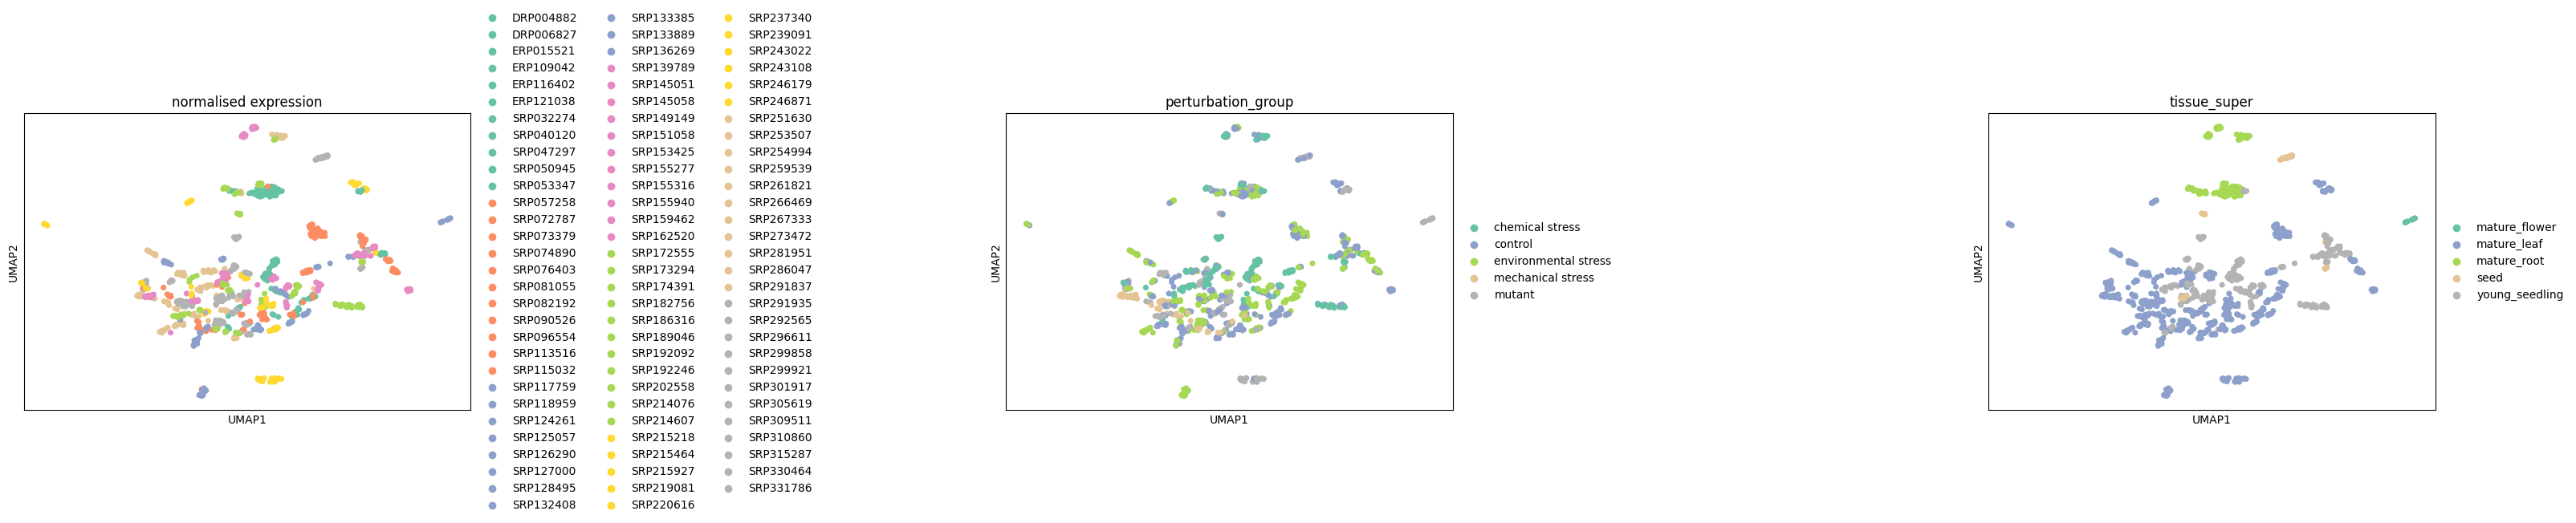

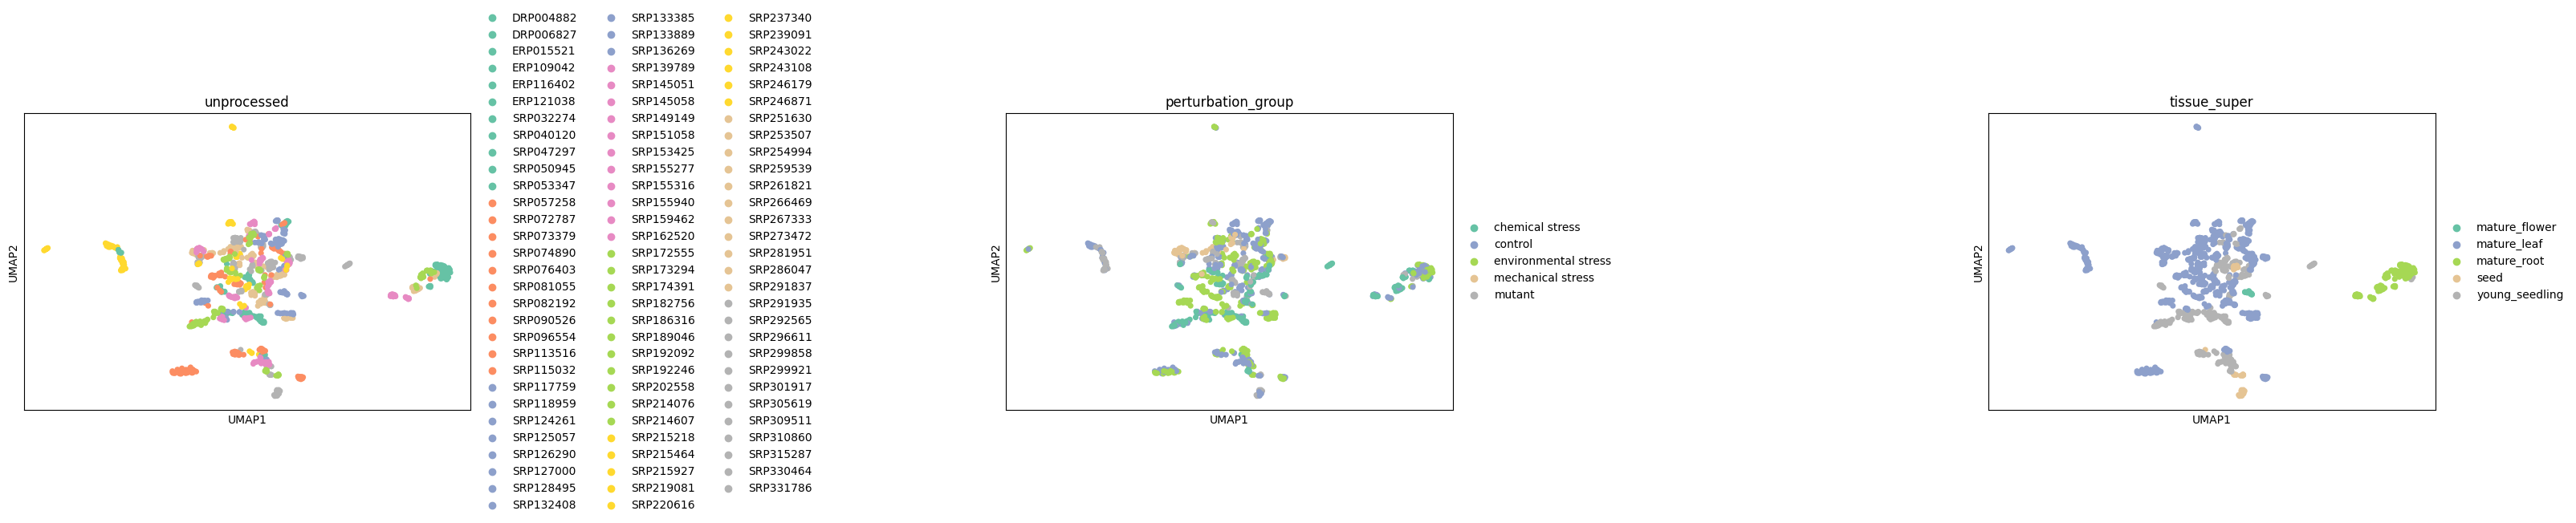

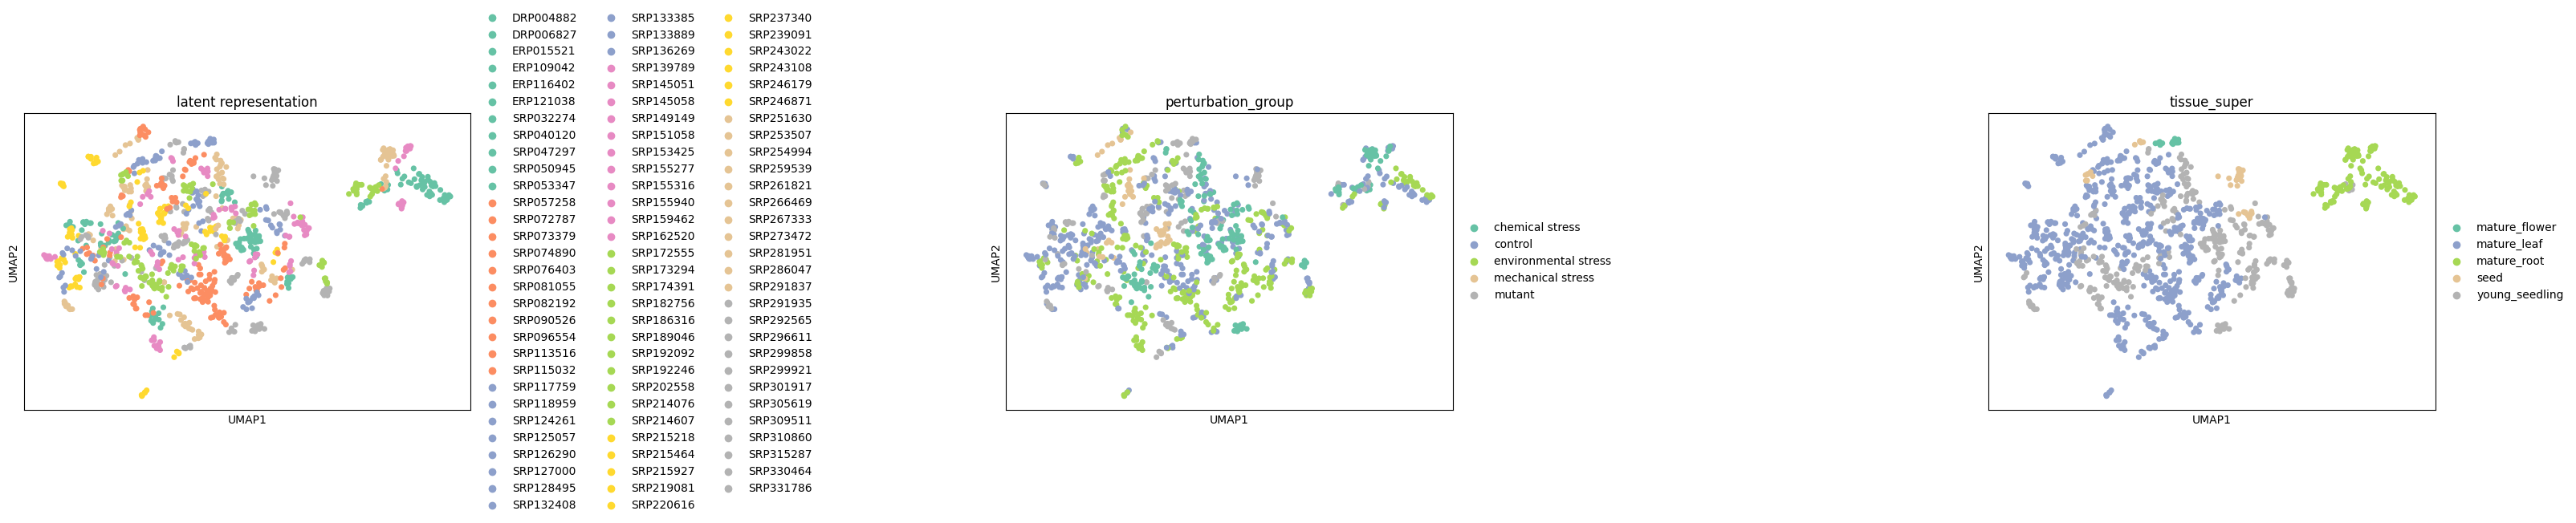

In [ ]:
adata_trim.obsm["X_scVI_norm"] = model_scvi.get_normalized_expression(adata_trim)

sc.pp.neighbors(adata_trim, use_rep="X_scVI_norm")
sc.tl.umap(adata_trim)

sc.pl.umap(adata_trim, color=['sra_study', 'perturbation_group', 'tissue_super'], title='normalised expression', palette='Set2', wspace=1)


sc.pp.neighbors(adata_trim, use_rep='X')
sc.tl.umap(adata_trim)

sc.pl.umap(adata_trim, color=['sra_study', 'perturbation_group', 'tissue_super'], title='unprocessed', palette='Set2', wspace=1)


adata_trim.obsm["X_scVI_lat"] = model_scvi.get_latent_representation(adata_trim)

sc.pp.neighbors(adata_trim, use_rep="X_scVI_lat")
sc.tl.umap(adata_trim)

sc.pl.umap(adata_trim, color=['sra_study', 'perturbation_group', 'tissue_super'], title='latent representation', palette='Set2', wspace=1)



In [ ]:
model_scvi.save("/content/drive/MyDrive/Mag/vae_model_tpm_cov1.pt")

In [ ]:
adata_trim.obs['sra_study']

KeyError: 'study_accession'

In [ ]:
from google.colab import files

df_lat = pd.DataFrame(adata_raw.obsm["X_scVI_lat"])
df_lat['SRR_accession'] = adata_raw.obs['sra_study'].index
df_lat.set_index('SRR_accession', inplace=True)

In [ ]:
df_lat.to_csv('vae_latent.tsv', sep='\t')
files.download('vae_latent.tsv')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
df_transformed = pd.DataFrame(adata_raw.obsm["X_scVI_norm"])
df_transformed['SRR_accession'] = adata_raw.obs['sra_study'].index
df_transformed.set_index('SRR_accession', inplace=True)

#df_transformed = df_transformed[df_transformed.columns.intersection(tpm_cols.columns)]

df_transformed.to_csv('vae_transformed.tsv', sep='\t')
files.download('vae_transformed.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
tpm_table = pd.read_table('/content/drive/MyDrive/Mag/athaliana_annotated.tsv', index_col=0)
metadata_table = pd.read_table('/content/drive/MyDrive/Mag/metadata_T.tsv', index_col=0)

tpm_table = metadata_table.join(tpm_table, how='inner')

tpm_table.drop(['qc_rate'], inplace=True, axis=1)


var = pd.DataFrame(tpm_table.columns[6:])
var = var.rename(columns={0: "gene_id"})
var.set_index('gene_id', inplace=True)

adata_raw = anndata.AnnData(X = tpm_table.iloc[0:,6:],
                        obs = pd.DataFrame(tpm_table['sra_study']),
                        var = var)

adata_raw.layers["counts"] = adata_raw.X


cat_cov_list = ['experiment_library_selection' ]

scvi.model.SCVI.setup_anndata(adata_raw, layer="counts", batch_key='sra_study')


model_scvi = scvi.model.SCVI(adata_raw, n_hidden=512, n_latent=32, n_layers=3)

model_scvi.view_anndata_setup()

max_epochs_scvi = int(np.min([round((20000 / adata_raw.n_obs) * 400), 400]))


#model_scvi.train(max_epochs=max_epochs_scvi, batch_size=32)

model_scvi = model_scvi.load('/content/drive/MyDrive/Mag/vae_model_tpm1.pt', adata_raw)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Mag/athaliana_annotated.tsv'

In [ ]:

adata_raw.obsm["X_scVI_norm"] = model_scvi.get_normalized_expression(adata_raw)

sc.pp.neighbors(adata_raw, use_rep="X_scVI_norm")
sc.tl.umap(adata_raw)

sc.pl.umap(adata_raw, color=['sra_study', 'perturbation_group', 'tissue_super'], title='normalised expression', palette='Set2', wspace=1)


sc.pp.neighbors(adata_raw, use_rep='X')
sc.tl.umap(adata_raw)

sc.pl.umap(adata_raw, color=['sra_study', 'perturbation_group', 'tissue_super'], title='unprocessed', palette='Set2', wspace=1)


adata_raw.obsm["X_scVI_lat"] = model_scvi.get_latent_representation(adata_raw)

sc.pp.neighbors(adata_raw, use_rep="X_scVI_lat")
sc.tl.umap(adata_raw)

sc.pl.umap(adata_raw, color=['sra_study', 'perturbation_group', 'tissue_super'], title='latent representation', palette='Set2', wspace=1)
